# 0.0. IMPORTS

In [92]:
import pandas as pd
import math
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# import inflection
import datetime
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

# sns.set_palette('icefire')
pd.set_option('display.max_columns', None)

## 0.1. Helper Functions

## 0.2. Loading Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [3]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [4]:
cols_old = df1.columns

# def snakecase(x):
#     return inflection.underscore(x)

# cols_new = list(map(snakecase, cols_old))
cols_new = ['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval']

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [5]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3. Data Types

In [6]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [8]:
df1['competition_distance'].max()

75860.0

In [9]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [10]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [13]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6])
m = m.T
m.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,min,max,range,mean,median,std,skew,kurtosis
store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


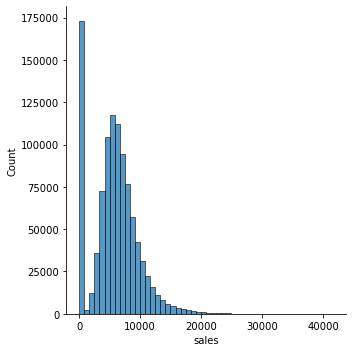

In [14]:
sns.displot(df1['sales'], bins=50)

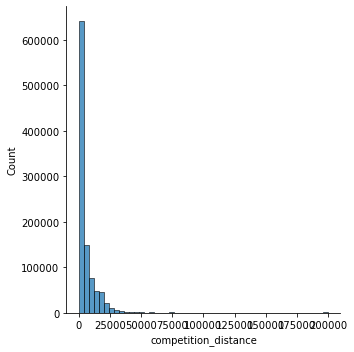

In [15]:
sns.displot(df1['competition_distance'], bins=50)

### 1.7.2. Categorical Attributes

In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [17]:
cat_attributes.describe()

,state_holiday,store_type,assortment,promo_interval,month_map
count,1017209,1017209,1017209,1017209,1017209
unique,4,4,3,4,12
top,0,a,a,0,May
freq,986159,551627,537445,508031,103695


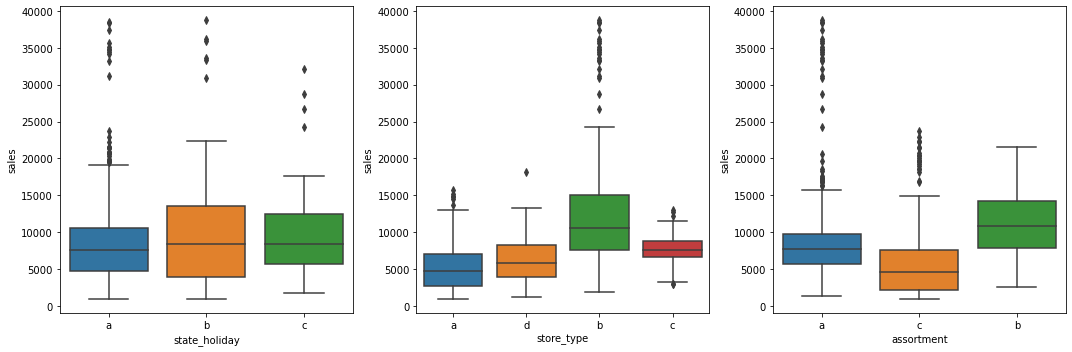

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

plt.tight_layout()

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

![Mind Map Hypothesis](img/MindMapHypothesis.png)

## 2.2. Criação das Hipoteses

### 2.2.1 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição do produto deveriam vender mais

**3.** Lojas com produtos com preço menos deveriam vender mais

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre dos ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveria vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Lista Final de Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre dos ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveria vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int64')


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [21]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIAVEIS

In [22]:
df3 = df2.copy()

In [23]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das colunas

In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [26]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0. PASSO 04 - EXPLORATORY DATA ANALYSIS

In [27]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [28]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 4.1.1 Response Variable

<AxesSubplot:xlabel='sales', ylabel='Count'>

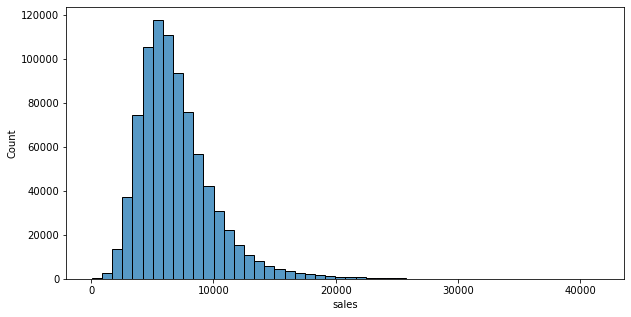

In [29]:
plt.figure(figsize=(10,5))
sns.histplot(data=df4, x='sales', bins=50)
# df4['sales'].hist(figsize=(10, 5), bins=50, grid=False)

### 4.1.2 Numerical Variable

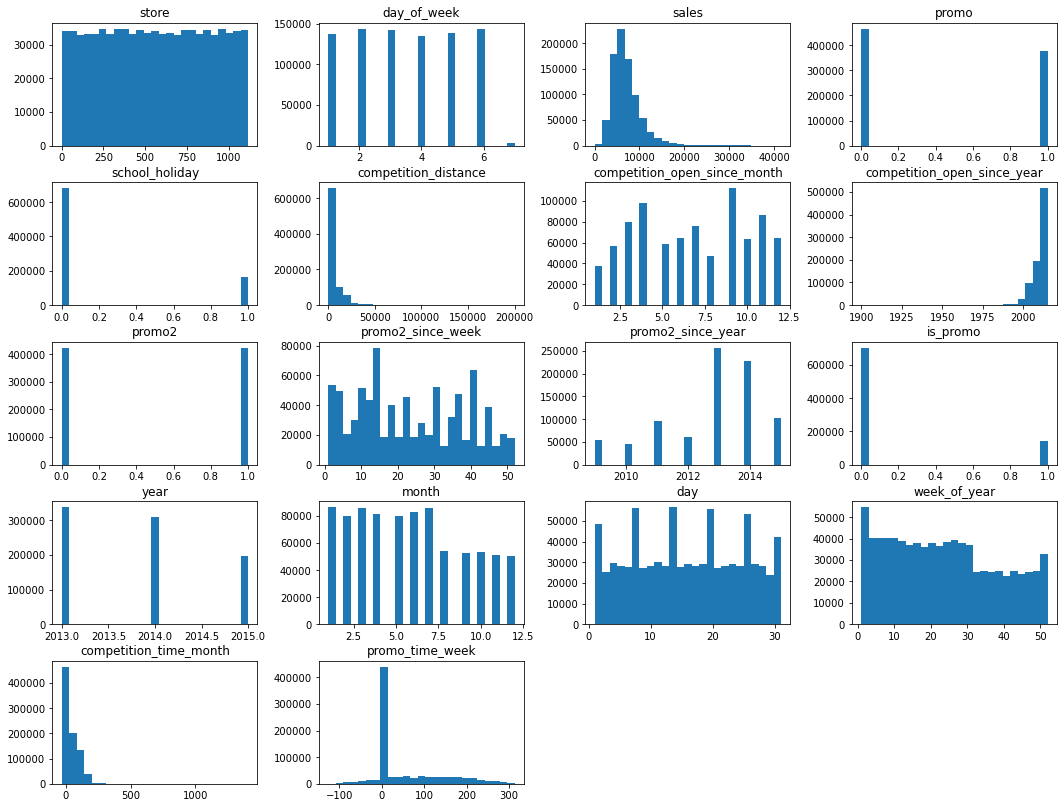

In [30]:
num_attributes.hist(bins=25, figsize=(18, 14), grid=False);

In [31]:
# Resumo descritivo "is_promo"
print('Resumo descritivo "is_promo"')
print('Minimum:  {:.2f}'.format(df4['is_promo'].min()))
print('Maximum:  {:.2f}'.format(df4['is_promo'].max()))
print('Std:      {:.2f}'.format(df4['is_promo'].std()))
print('Range:    {:.2f}'.format(df4['is_promo'].max() - df4['is_promo'].min()))
print('Kurtosis: {:.2f}'.format(df4['is_promo'].kurtosis()))
print('Skew:     {:.2f}'.format(df4['is_promo'].skew()))

Resumo descritivo "is_promo"
Minimum:  0.00
Maximum:  1.00
Std:      0.37
Range:    1.00
Kurtosis: 1.22
Skew:     1.80


### 4.1.3 Categorical Variable

In [32]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

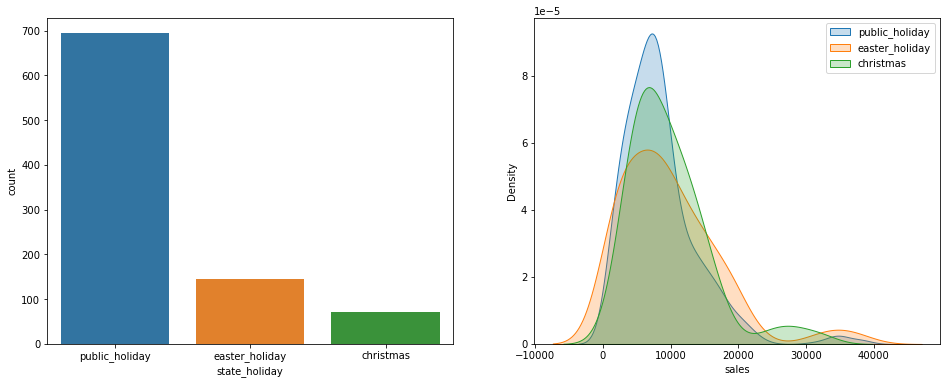

In [33]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data=a, x='state_holiday')

plt.subplot(1, 2, 2)
sns.kdeplot(df4.loc[df4['state_holiday'] == 'public_holiday', 'sales'], label='public_holiday', shade=True)
sns.kdeplot(df4.loc[df4['state_holiday'] == 'easter_holiday', 'sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4.loc[df4['state_holiday'] == 'christmas', 'sales'], label='christmas', shade=True)
plt.legend()

In [34]:
df4['store_type'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

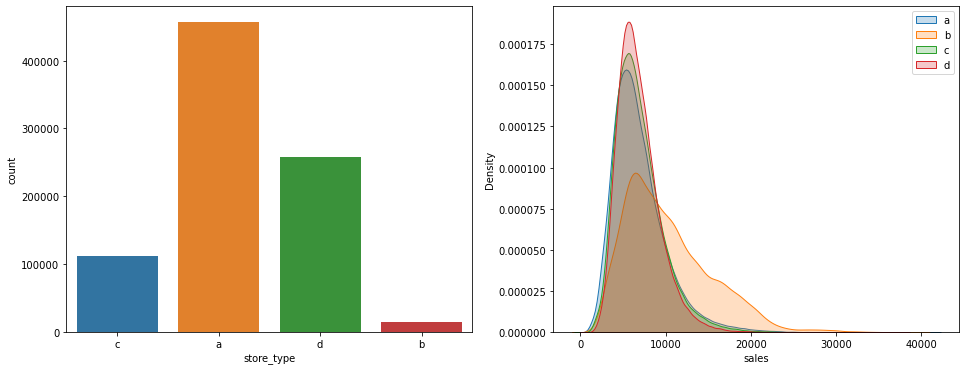

In [35]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
sns.countplot(data=df4, x='store_type')

plt.subplot(1, 2, 2)
sns.kdeplot(df4.loc[df4['store_type'] == 'a', 'sales'], label='a', shade=True)
sns.kdeplot(df4.loc[df4['store_type'] == 'b', 'sales'], label='b', shade=True)
sns.kdeplot(df4.loc[df4['store_type'] == 'c', 'sales'], label='c', shade=True)
sns.kdeplot(df4.loc[df4['store_type'] == 'd', 'sales'], label='d', shade=True)
plt.legend()

In [36]:
df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

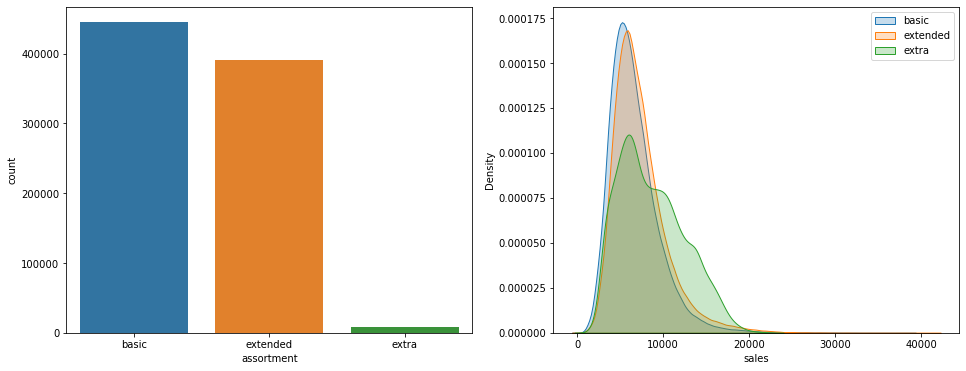

In [37]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
sns.countplot(data=df4, x='assortment')

plt.subplot(1, 2, 2)
sns.kdeplot(df4.loc[df4['assortment'] == 'basic', 'sales'], label='basic', shade=True)
sns.kdeplot(df4.loc[df4['assortment'] == 'extended', 'sales'], label='extended', shade=True)
sns.kdeplot(df4.loc[df4['assortment'] == 'extra', 'sales'], label='extra', shade=True)
plt.legend()

## 4.2. Bivariate Analysis

### H1. Lojas com maior sortimento deveriam vender mais.
**FALSO** - Lojas com MAIOR SORTIMENTO vendem MENOS

In [38]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

<AxesSubplot:xlabel='assortment', ylabel='sales'>

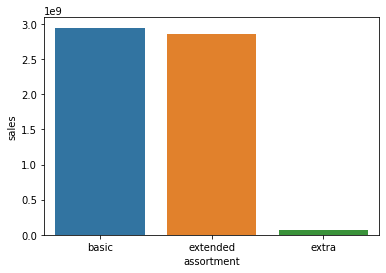

In [39]:
sns.barplot(data=aux1, x='assortment', y='sales')

In [40]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week' ,'assortment']).sum().reset_index()

In [41]:
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


<AxesSubplot:xlabel='year_week'>

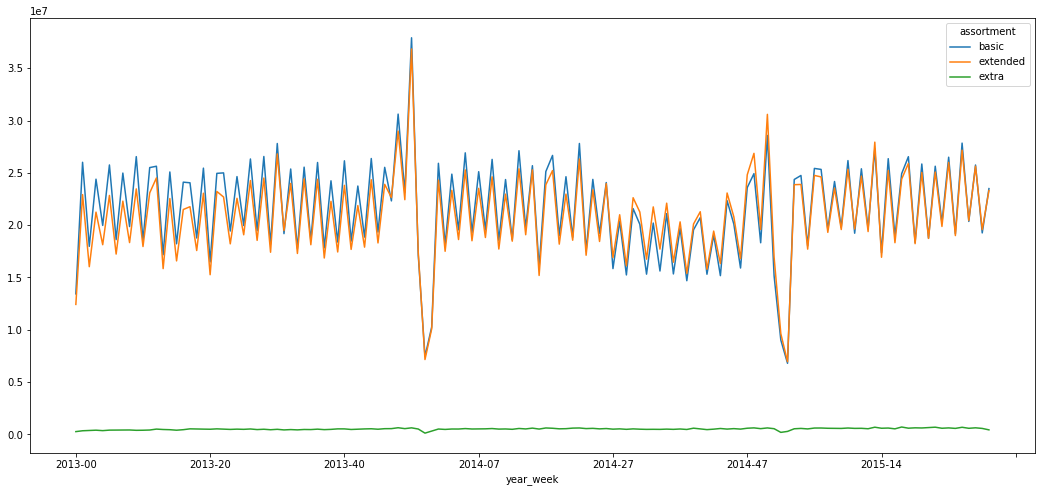

In [42]:
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(18,8))

<AxesSubplot:xlabel='year_week'>

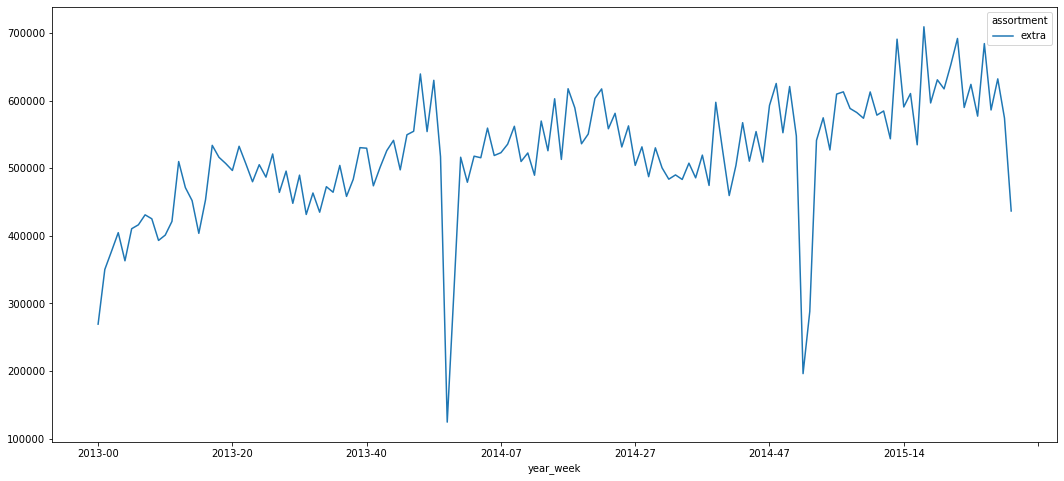

In [43]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(18, 8))

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSO** - Lojas com COMPETIDORES mais PRÓXIMOS vendem MAIS

<AxesSubplot:>

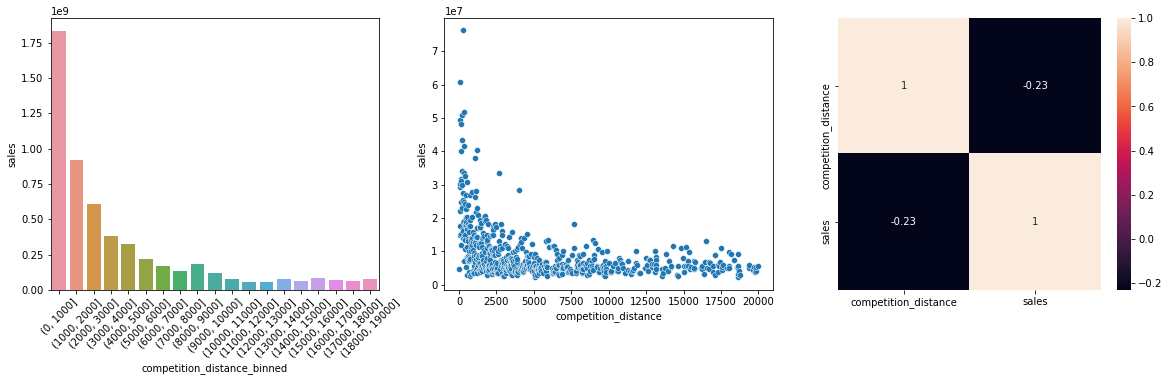

In [44]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.barplot(data=aux2, x='competition_distance_binned', y='sales', )
plt.xticks(rotation=45);

plt.subplot(1, 3, 2)
sns.scatterplot(data=aux1[aux1['competition_distance'] < 20000], x='competition_distance', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

# plt.title('competition_distance Analysis')

<AxesSubplot:>

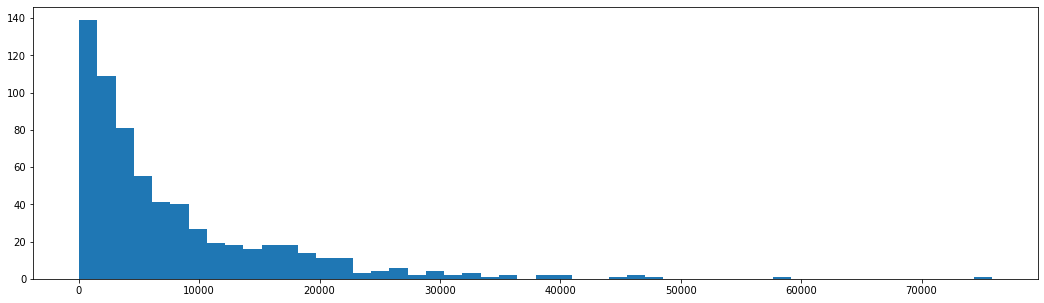

In [45]:
aux1.loc[aux1['competition_distance'] < 200000, 'competition_distance'].hist(bins=50, figsize=(18, 5), grid=False)

### H3. Lojas com competidores há mais tempo deveriam vender mais.
**FALSO** - Lojas com competidores há MAIS TEMPO vendem MENOS

<AxesSubplot:>

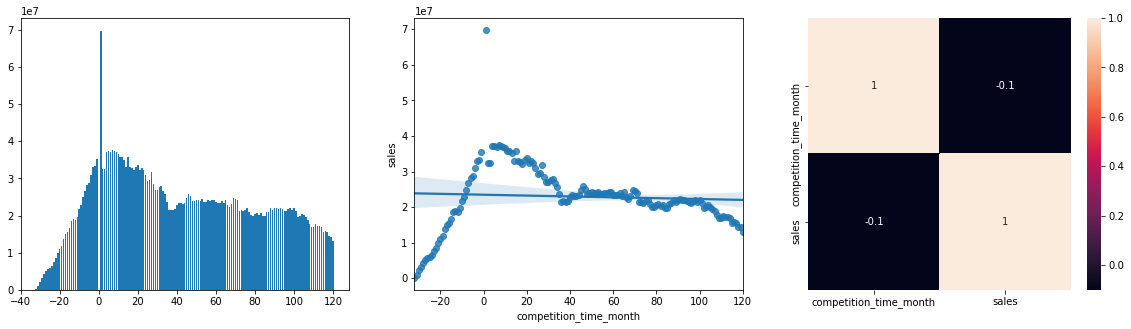

In [46]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] <= 120) & (aux1['competition_time_month'] != 0)]

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
# sns.barplot(data=aux2, x='competition_time_month', y='sales')
plt.bar(x=aux2['competition_time_month'], height=aux2['sales'])

plt.subplot(1, 3, 2)
sns.regplot(data=aux2, x='competition_time_month', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSO** - Lojas com promoções ativas por mais tempo vendem menos depois de um certo tempo de promoção

<AxesSubplot:>

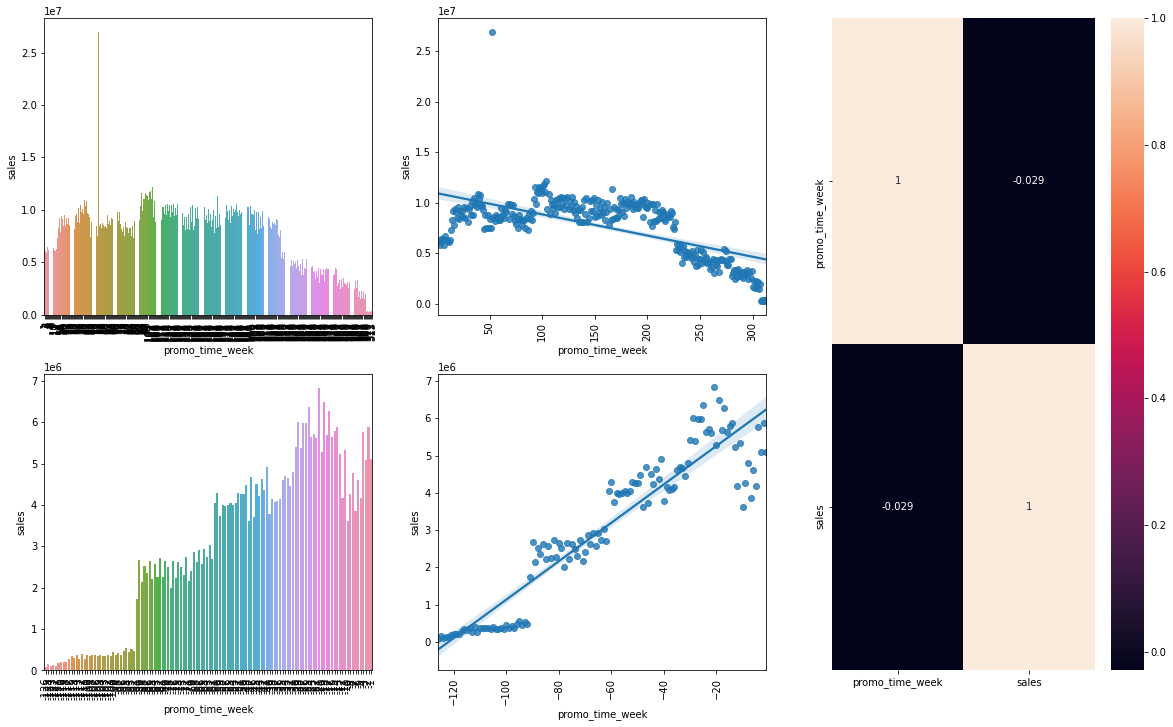

In [47]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
# sns.barplot(data=aux1, x='promo_time_week', y='sales')

aux2 = aux1[aux1['promo_time_week'] > 0] # promo extended
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular

plt.figure(figsize=(20,12))

grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, 0])
sns.barplot(data=aux2, x='promo_time_week', y='sales')
# plt.bar(x=aux2['promo_time_week'], height=aux2['sales'])
plt.xticks(rotation=90);

plt.subplot(grid[0, 1])
sns.regplot(data=aux2, x='promo_time_week', y='sales')
plt.xticks(rotation=90);

plt.subplot(grid[1, 0])
sns.barplot(data=aux3, x='promo_time_week', y='sales')
# plt.bar(x=aux3['promo_time_week'], height=aux3['sales'])
plt.xticks(rotation=90);

plt.subplot(grid[1, 1])
sns.regplot(data=aux3, x='promo_time_week', y='sales')
plt.xticks(rotation=90);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSO** - Lojas com mais promoções consecutivas vendem menos

In [48]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


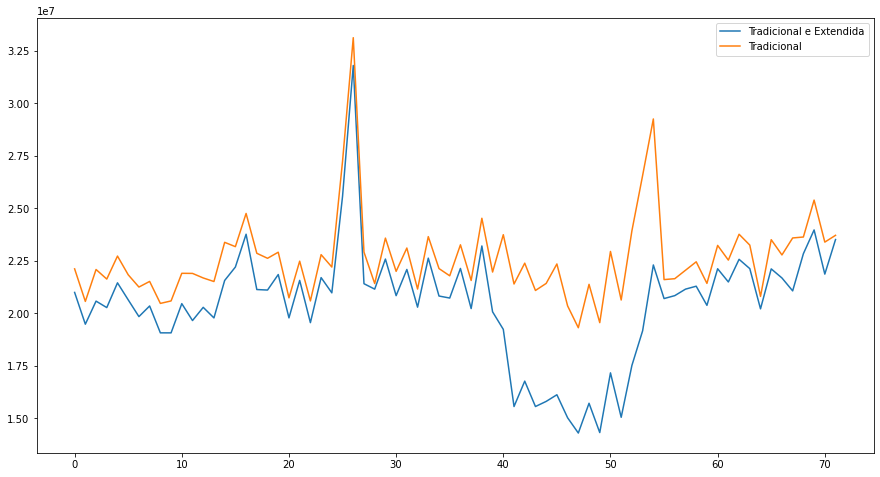

In [49]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(15,8))

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida', 'Tradicional'])

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSO** - Lojas abertas durante o feriado de Natal vendem menos

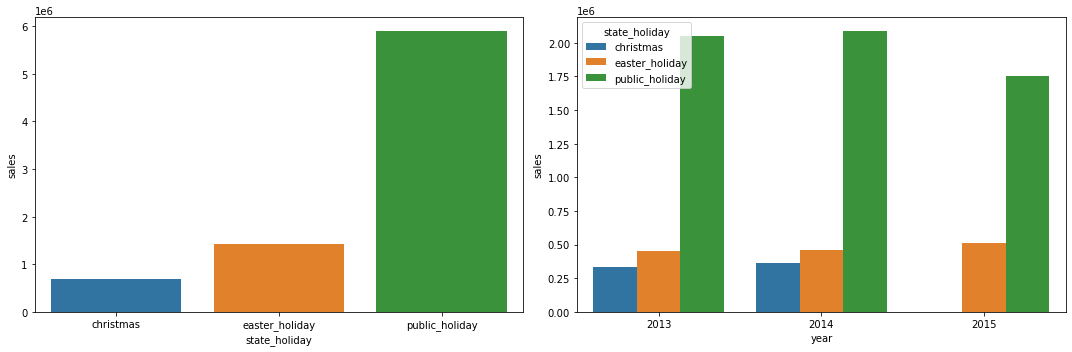

In [50]:
aux = df4[df4['state_holiday']  != 'regular_day']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data=aux1, x='state_holiday', y='sales')

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='year', y='sales', hue='state_holiday')

plt.tight_layout()

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSO** - Lojas vendem menos ao longo dos anos

<AxesSubplot:>

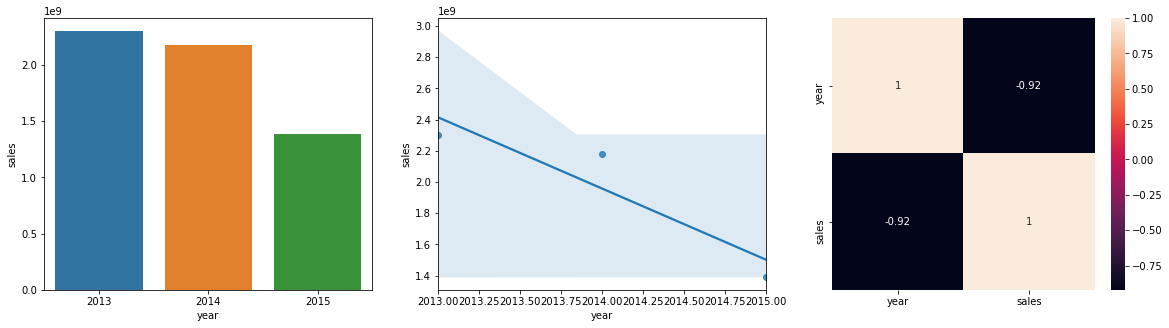

In [51]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='year', y='sales')

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='year', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True)

### H9. Lojas deveriam vender mais no segundo semestre dos ano.
**FALSO** Lojas apresentam quedas nas vendas apos o 6° mês, com um aumento em dezembro.

<AxesSubplot:>

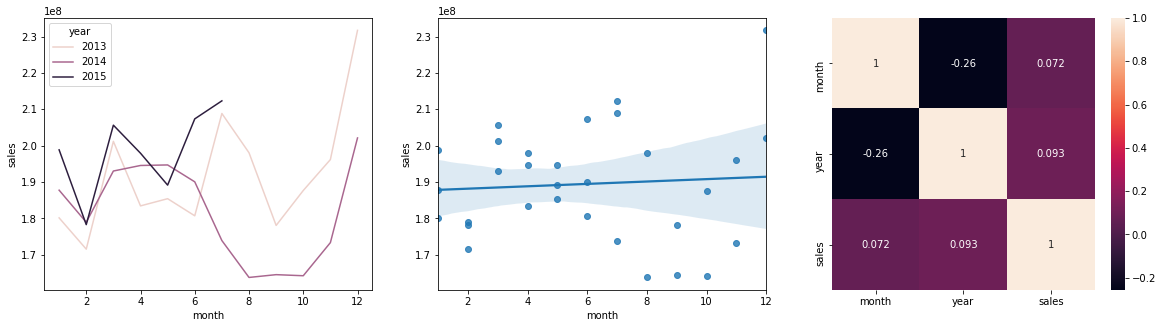

In [52]:
aux1 = df4[['month', 'year', 'sales']].groupby(['month', 'year']).sum().reset_index()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.lineplot(data=aux1, x='month', y='sales', hue='year')

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='month', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True)

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRO** - Lojas vendem mais após o dia 10. 

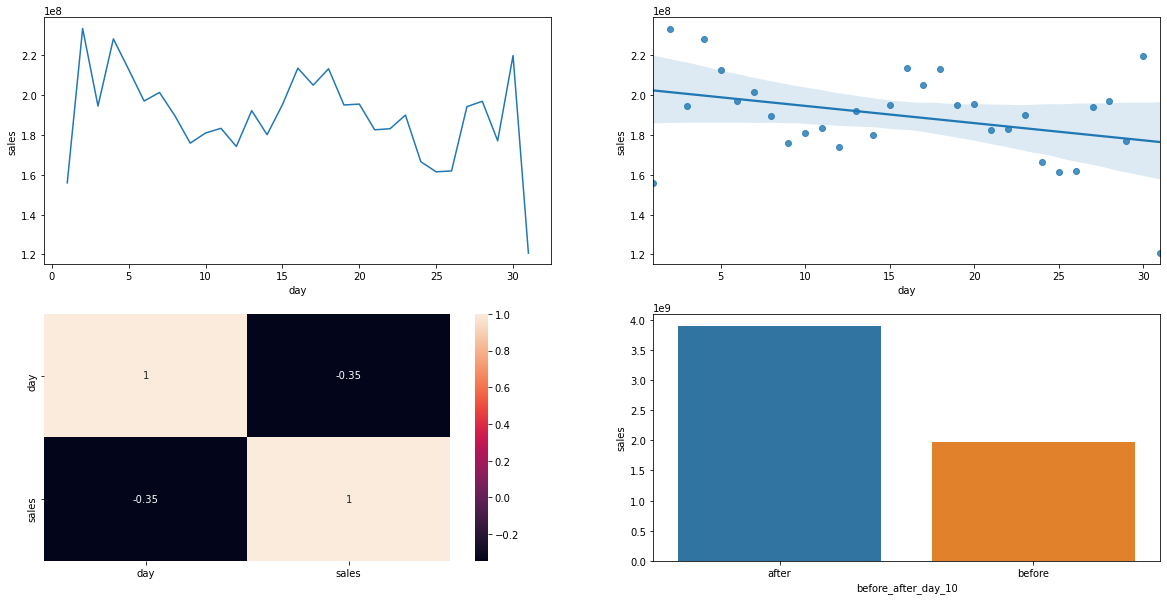

In [53]:
aux1 = df4[['day', 'sales']].groupby(['day']).sum().reset_index()
aux1['before_after_day_10'] = aux1['day'].apply(lambda x: 'before' if x <= 10 else 'after')

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
sns.lineplot(data=aux1, x='day', y='sales');

plt.subplot(2, 2, 2)
sns.regplot(data=aux1, x='day', y='sales');

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(), annot=True);

aux2 = aux1[['before_after_day_10', 'sales']].groupby('before_after_day_10').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(data=aux2, x='before_after_day_10', y='sales');

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRO** - Lojas vendem menos aos finais de semana.

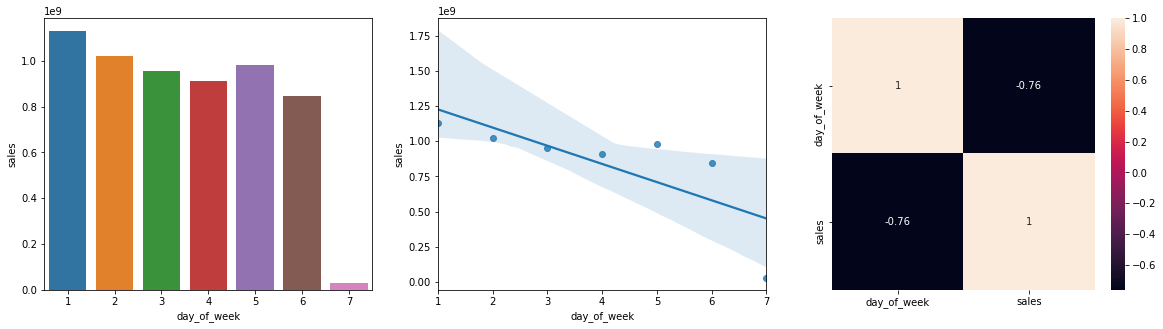

In [54]:
aux1 = df4[['day_of_week', 'sales']].groupby(['day_of_week']).sum().reset_index()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
**FALSO** - Lojas vendem, em media, mais durante os feriados escolares.

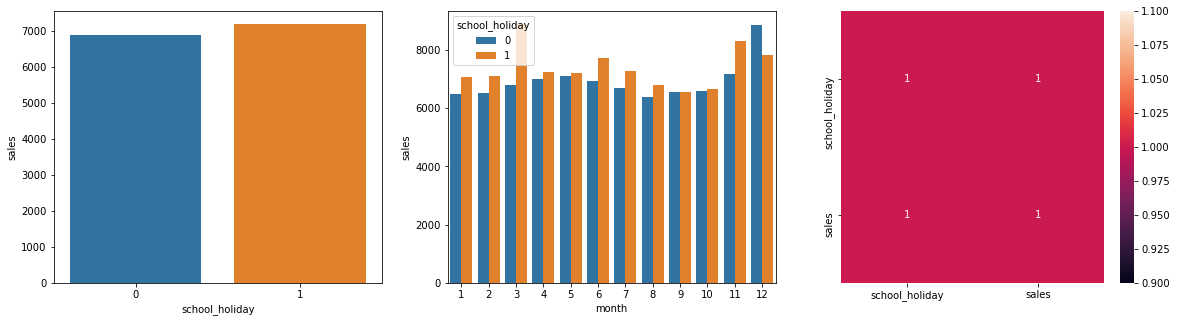

In [55]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).mean().reset_index()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='school_holiday', y='sales');

plt.subplot(1, 3, 2)
sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday');

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### 4.2.1. Resumo das Hipóteses

|Hipotese|Conclusão|Relevânicia|
|---|---|---|
|H1 |Falsa     |Baixa|
|H2 |Falsa     |Media|
|H3 |Falsa     |Media|
|H4 |Falsa     |Baixa|
|H5 |-         |-    |
|H6 |Falsa     |Baixa|
|H7 |Falsa     |Media|
|H8 |Falsa     |Alta |
|H9 |Falsa     |Alta |
|H10|Verdadeira|Alta |
|H11|Verdadeira|Alta |
|H12|Verdadeira|Baixa|

## 4.3. Multivariate Analysis

### 4.3.1 Numerical Attributes

<AxesSubplot:>

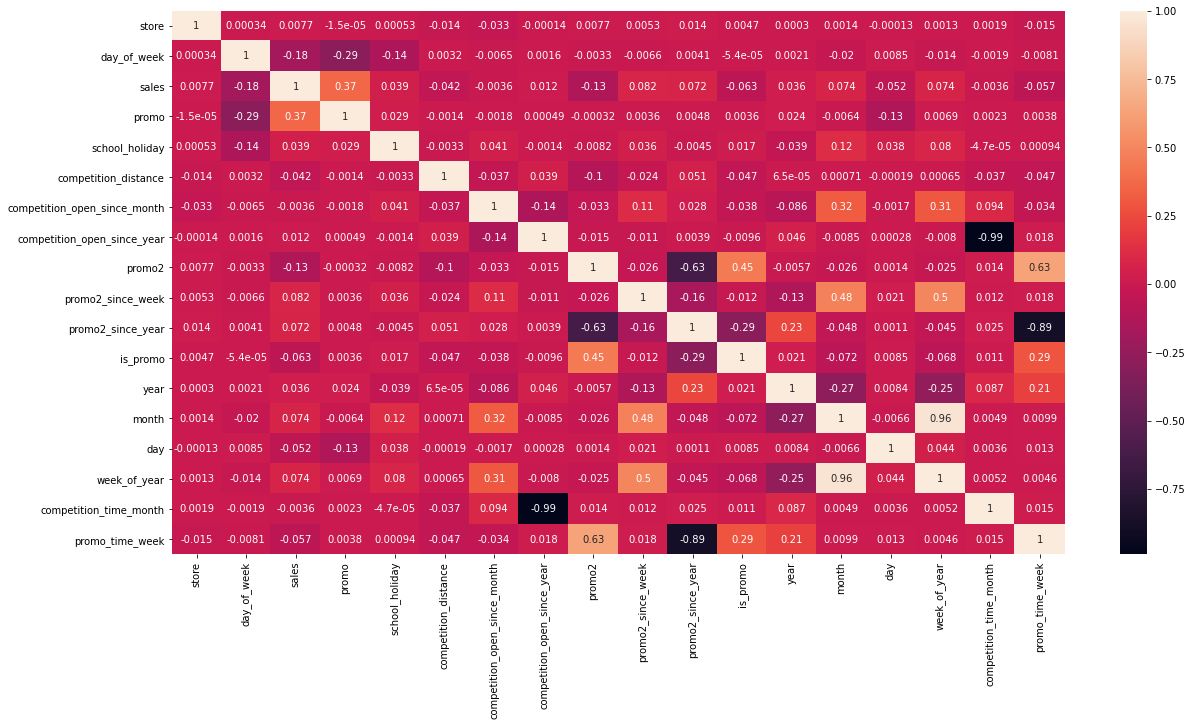

In [56]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

In [57]:
a = df4.select_dtypes(include=['object']).drop('year_week', axis=1)
a.head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


In [58]:
def cramerv(x, y):
    cm = pd.crosstab(x, y).values
    chi2 = stats.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    v = np.sqrt((chi2/n) / min(k-1, r-1))
    
    chi2_corr = max(0, chi2 - (((k-1)*(r-1)) / (n-1)))
    k_corr = k - (k-1)**2 / (n-1)
    r_corr = r - (r-1)**2 / (n-1)
    v_corr = np.sqrt((chi2_corr/n) / min(k_corr-1, r_corr-1))
    
    return v_corr

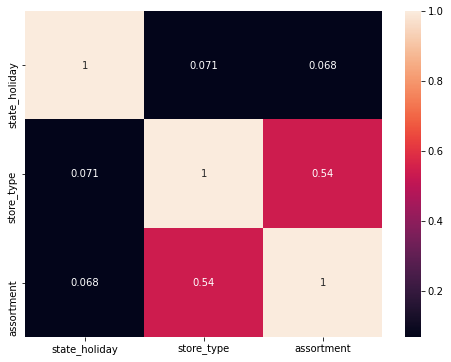

In [60]:
d = pd.DataFrame()
aux = []
for i in a.columns:
    for j in a.columns:
        v = cramerv(a[i], a[j])
        aux.append(v)
    d[i] = aux.copy()
    aux.clear()
d = d.set_index(d.columns)

plt.figure(figsize=(8,6))
sns.heatmap(d, annot=True);

# 5.0. PASSO 05 - DATA PREPARATION

In [61]:
df5 = df4.copy()

## 5.1 Standardization

In [62]:
# Nenhuma variável com distribuição próxima à normal

## 5.2 Rescaling

In [65]:
a = df5.select_dtypes(include=['int64', 'float64'])

C:\Users\Aliss\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

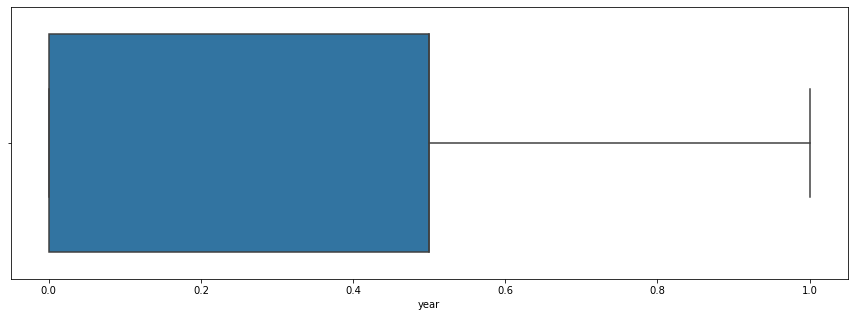

In [87]:
plt.figure(figsize=(15,5))
sns.boxplot(df5['year'])

In [73]:
rs = RobustScaler()
mms = MinMaxScaler()

In [75]:
# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

<AxesSubplot:xlabel='competition_distance', ylabel='Count'>

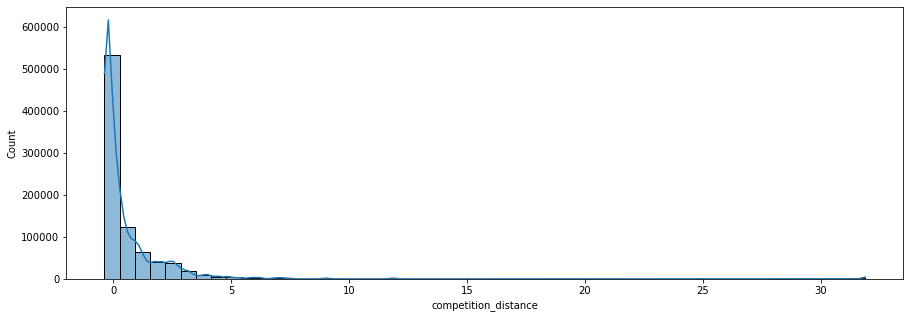

In [88]:
plt.figure(figsize=(15,5))
sns.histplot(df5['competition_distance'], bins=50, kde=True)

## 5.3 Transformation

### 5.3.1 Encoding

In [90]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [ ]:
# day_of_week
# month
# day
# week_of_year